## Layers and hodoscopes


The default *layer* class `PanelDetectorLayer` in TomOpt uses multiple *panels* `DetectorPanel` to record muon position.

`PanelDetectorLayer` inherits from the `AbsDetectorLayer` and **MUST** provide the following **methods**:

 - `forward`: The forward method to propagate the muons. It is a central aspect of `nn.Module`.
 - `get_cost`
 - `conform_detector`
  - `assign_budget`

and the following **features**:

 - `pos`: the position of the layer, either `above` or `bellow`. 
 - `lw`: the length and width of the layer.
 - `z`: the z position of the top of gthe layer. 
 - `size`: the heigth of the layer such that z - size is the bottom of the layer.
 - `device`: torch.device.

In [1]:
from torch import Tensor
# from torch import nn
from hodoscope import Hodoscope
from hodoscopelayer import HodoscopeDetectorLayer

# Up

hod1 = Hodoscope(init_xyz= [.5, .5, 1.3], 
                 init_xyz_span = [1., 1., .3], 
                 xyz_gap = [.1, .1, .1])

hod2 = Hodoscope(init_xyz = [0.5, 0.5, 1.], 
                 init_xyz_span = [1., 1., .3], 
                 xyz_gap = [.1, .1, .1])


hods = [hod1, hod2]

hod_detector_above = HodoscopeDetectorLayer(pos = 'above', lw = Tensor([1,1]), z = 1., size = 0.5, 
                                            hodoscopes = hods)

# Down

hod3 = Hodoscope(init_xyz= [.5, .5, 0.0], 
                 init_xyz_span = [1., 1., .3], 
                 xyz_gap = [.1, .1, .1])

hod4 = Hodoscope(init_xyz = [0.5, 0.5, -.3], 
                 init_xyz_span = [1., 1., .3], 
                 xyz_gap = [.1, .1, .1])


hods_down = [hod3, hod4]

hod_detector_below = HodoscopeDetectorLayer(pos = 'below', lw = Tensor([1,1]), z = 1., size = 0.5, 
                                            hodoscopes = hods_down)

# hodoscope layers

hod_layers = [hod_detector_above, hod_detector_below]

In [2]:
from tomopt.volume.layer import PassiveLayer
import torch
from torch import Tensor, nn
DEVICE = torch.device("cpu")

def get_layers(hod_layers):
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e3
    n_panels = 4
    layers.append(hod_layers[0])
    for z in [0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    
    layers.append(hod_layers[1])

    return nn.ModuleList(layers) 

In [3]:
from tomopt.volume import Volume
volume = Volume(get_layers(hod_layers))

## Propagate muons

Let's try to **propagate muons** through the volume and make sure that muon **detection runs** smoothly.

In [4]:
n_muons = 1000
xyz = torch.zeros(n_muons)
xy_p_theta_phi = torch.ones([1000,5])

# xy pos at the center of panels
xy_p_theta_phi[:,:2] = 0.5

# theta for vertical muons
xy_p_theta_phi[:,3] = 0.01

# Generate muons
from tomopt.muon import MuonBatch
muons = MuonBatch(init_z=1.5,xy_p_theta_phi = xy_p_theta_phi)



In [5]:
# propagate muons throught the volume
volume(muons)

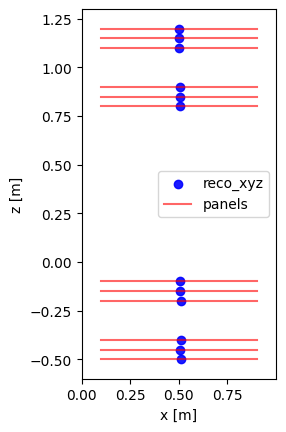

In [6]:
import numpy as np
event = np.random.randint(0,n_muons)

from plotting import plot_hits
plot_hits(volume=volume, muons=muons, event = event, hits = 'reco_xyz')

It seems that the **hits recording** procedure **run smoothly**! Let's check the behaviour for a realistic muon source.

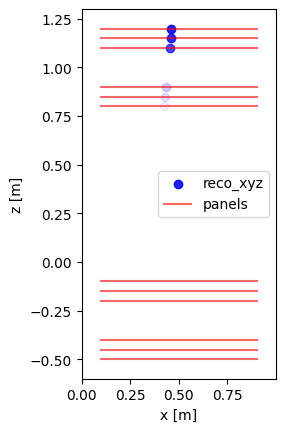

In [16]:
# Create muon generator
from tomopt.muon import MuonGenerator2015
generator = MuonGenerator2015(x_range=[.1,.9], y_range=[.1,.9])

# Generate muons
from tomopt.muon import MuonBatch
muons = MuonBatch(init_z=1.5,xy_p_theta_phi = generator.generate_set(n_muons))

# propagate muons throught the volume
volume(muons)

# plot reco hits
event = np.random.randint(0,n_muons)
plot_hits(volume=volume, muons=muons, event = event, hits = 'reco_xyz')

What happens when the hodoscopes are **not placed** directly on **top of each other**?

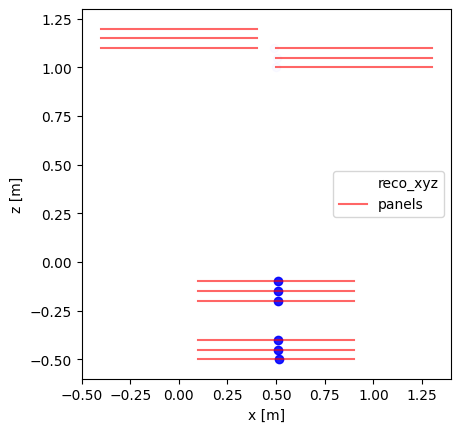

In [17]:
# Up

hod1 = Hodoscope(init_xyz= [0., 0., 1.3], 
                 init_xyz_span = [1., 1., .3], 
                 xyz_gap = [.1, .1, .1])

hod2 = Hodoscope(init_xyz = [0.9, 0.9, 1.2], 
                 init_xyz_span = [1., 1., .3], 
                 xyz_gap = [.1, .1, .1])


hods = [hod1, hod2]

hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                            lw = Tensor([2,2]), 
                                            z = 1., size = 0.5, 
                                            hodoscopes = hods)

# Down

hod3 = Hodoscope(init_xyz= [.5, .5, 0.0], 
                 init_xyz_span = [1., 1., .3], 
                 xyz_gap = [.1, .1, .1])

hod4 = Hodoscope(init_xyz = [0.5, 0.5, -.3], 
                 init_xyz_span = [1., 1., .3], 
                 xyz_gap = [.1, .1, .1])


hods_down = [hod3, hod4]

hod_detector_below = HodoscopeDetectorLayer(pos = 'below', lw = Tensor([1,1]), z = 1., size = 0.5, 
                                            hodoscopes = hods_down)

# hodoscope layers

hod_layers = [hod_detector_above, hod_detector_below]

def get_layers(hod_layers):
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e3
    n_panels = 4
    layers.append(hod_layers[0])
    for z in [0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    
    layers.append(hod_layers[1])

    return nn.ModuleList(layers)

from tomopt.volume import Volume
volume = Volume(get_layers(hod_layers))

n_muons = 1000
xyz = torch.zeros(n_muons)
xy_p_theta_phi = torch.ones([1000,5])

# xy pos at the center of panels
xy_p_theta_phi[:,:2] = 0.5

# theta for vertical muons
xy_p_theta_phi[:,3] = 0.01

# Generate muons
from tomopt.muon import MuonBatch
muons = MuonBatch(init_z=1.5,xy_p_theta_phi = xy_p_theta_phi)

# propagate muons throught the volume
volume(muons)

event = np.random.randint(0,n_muons)

from plotting import plot_hits
plot_hits(volume=volume, muons=muons, event = event, hits = 'reco_xyz')

In [18]:
from tomopt.inference.scattering import ScatterBatch

sb = ScatterBatch(mu=muons, volume=volume)

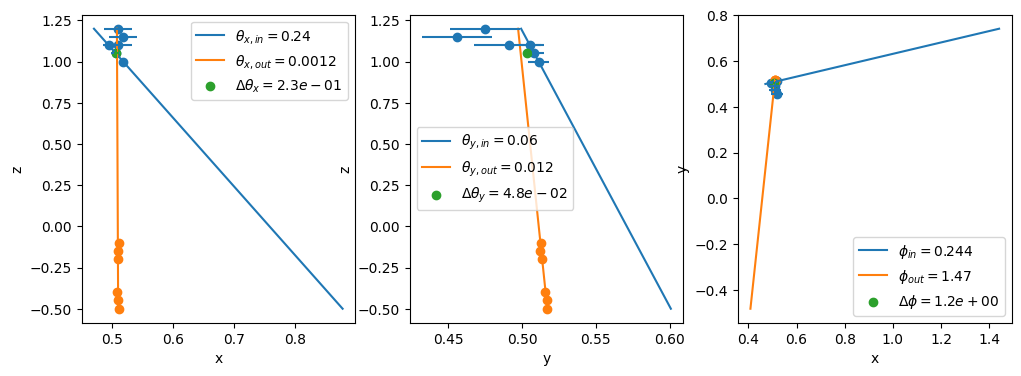

In [20]:
sb.plot_scatter(idx=np.random.randint(n_muons))